In [6]:
import os 
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *

# Loading Data 

In [7]:
class House: 
  def __init__(self, address, postal_code, type, real_price, 
                size, basement_size, rooms, year_built, 
                year_rebuilt, energy_label, image_floorplan): 
    
    #Textual Data 
    self.address = address  
    self.postal_code = postal_code
    self.type = type
    self.price = real_price
    self.size = size
    self.basement_size = basement_size
    self.rooms = rooms
    self.year_built = year_built
    self.year_rebuilt = year_rebuilt
    self.energy_label = energy_label

    #Image Data 
    self.image_floorplan = image_floorplan
    
    #Predictions 
    self.predicted_price = None


def load_jpg_and_json(folder_path:str) -> (dict, np.ndarray):
  files = os.listdir(folder_path)
  jpg_file_path = None
  json_file_path = None

  # Find the jpg and json file in the folder
  for filename in files:
    if filename.endswith(".jpg"):
      jpg_file_path = os.path.join(folder_path, filename)
    elif filename.endswith(".json"):
      json_file_path = os.path.join(folder_path, filename)

  # Load the jpg
  image_data = cv2.imread(jpg_file_path)
  # Load the json
  with open(json_file_path, "r", encoding="utf-8") as file:
    json_data = json.load(file)

  if image_data is None:
    raise Exception(f"Error loading image {jpg_file_path}")
  if json_data is None:
    raise Exception(f"Error loading json {json_file_path}")

  return json_data, image_data

def create_house_instance(json_data, jpg): 
  address = json_data["address"]
  postal_code = json_data["postal_code"]
  type = json_data["type"]
  price = json_data["price"]
  size = json_data["size"]
  basement_size = json_data["basement_size"]
  rooms = json_data["rooms"]
  year_built = json_data["year_built"]
  year_rebuilt = json_data["year_rebuilt"] if json_data["year_rebuilt"] else None
  energy_label = json_data["energy_label"]
  image_floorplan = jpg

  house = House(address, postal_code, type, price, 
                size, basement_size, rooms, year_built, 
                year_rebuilt, energy_label, image_floorplan)
  return house

def load_houses(folder_path: str, max_houses: int = None):
    houses = []
    count = 0  # Counter to track the number of loaded houses
    for folder in os.listdir(folder_path):
        if max_houses is not None and count >= max_houses:
            break  # Stop loading houses if the maximum number is reached
        try:
            json_data, jpg = load_jpg_and_json(os.path.join(folder_path, folder))
            house = create_house_instance(json_data, jpg)
            houses.append(house)
            count += 1
        except Exception as e:
            print(f"Error loading house {folder}: {e}")
    return houses

#If we want to work with a DF 
def data_to_DF(houses: list[House])-> pd.DataFrame:
  data = []
  for house in houses:
    data.append([house.address, house.postal_code, house.type, house.price, 
                house.size, house.basement_size, house.rooms, house.year_built, 
                house.year_rebuilt, house.energy_label, house.image_floorplan])
  df = pd.DataFrame(data, columns = ["address", "postal_code", "type", "price", 
                "size", "basement_size", "rooms", "year_built", 
                "year_rebuilt", "energy_label", "image_floorplan"])
  return df

In [8]:
path = "../nybolig-scrape/output"
houses = load_houses(path, max_houses=1000)
houses_df = data_to_DF(houses)
display(houses_df.head())

Error loading house A R Friis Vej 9 3100 Hornbæk: Error loading image ../nybolig-scrape/output\A R Friis Vej 9 3100 Hornbæk\0.jpg
Error loading house A. Koldings Vej 8 Sillerslev 7990 Øster Assels: Error loading image ../nybolig-scrape/output\A. Koldings Vej 8 Sillerslev 7990 Øster Assels\0.jpg
Error loading house Aabenraavej 103 Ragebøl 6400 Sønderborg: Error loading image ../nybolig-scrape/output\Aabenraavej 103 Ragebøl 6400 Sønderborg\0.jpg
Error loading house Aakjærvej 29 Falling 8300 Odder: Error loading image ../nybolig-scrape/output\Aakjærvej 29 Falling 8300 Odder\0.jpg
Error loading house Aalborgvej 108 Brøndum 9670 Løgstør: Error loading image ../nybolig-scrape/output\Aalborgvej 108 Brøndum 9670 Løgstør\0.jpg
Error loading house Abelonelundvej 56 Røjle 5500 Middelfart: Error loading image ../nybolig-scrape/output\Abelonelundvej 56 Røjle 5500 Middelfart\0.jpg
Error loading house Abildgårdsvej 13 4520 Svinninge: Error loading image ../nybolig-scrape/output\Abildgårdsvej 13 4520 

,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
0,Aabenraavej 59 6100 Haderslev,6100,villa,2495000,226,35.0,6,1947,2010.0,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,Aagade 4 Vegger 9240 Nibe,9240,villa,495000,159,59.0,4,1958,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,Aalborgvej 224 Holtet 9362 Gandrup,9362,villa,795000,180,68.0,6,1952,1995.0,E,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,Aalborgvej 4 Hornum 9600 Aars,9600,villa,795000,187,0.0,6,1927,1980.0,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,Aavej 10 5856 Ryslinge,5856,villa,1195000,210,0.0,8,1880,1998.0,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

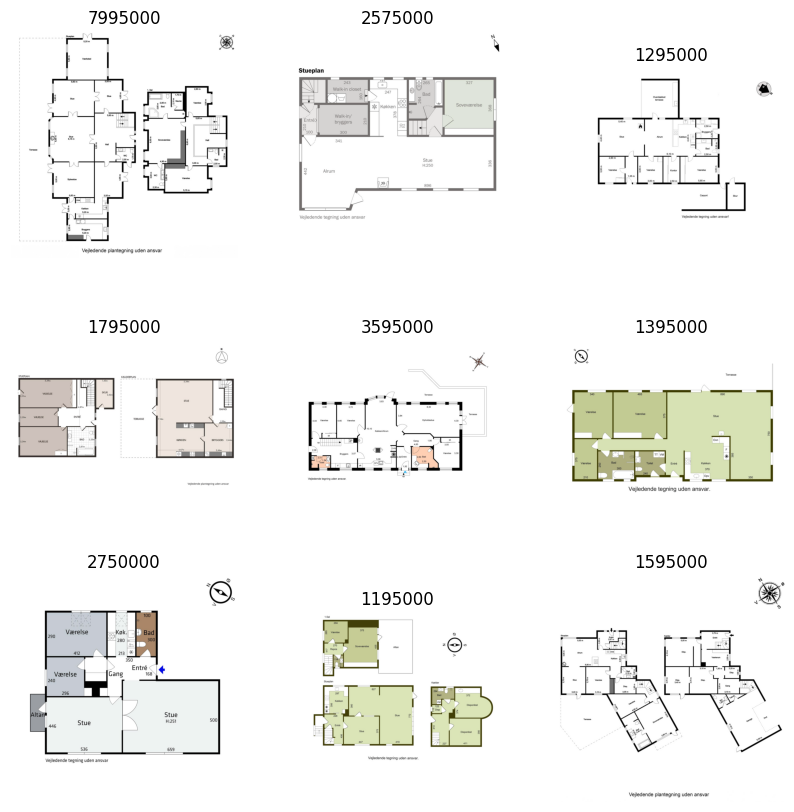

In [10]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(train_df["image_floorplan"][0:9], train_df["price"][0:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis("off")

# Pre-trained VGG16

In [11]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [12]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Set the GPU to be used
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available")

No GPU available


In [13]:
# Reshape the images to the desired size
train_images = np.array([cv2.resize(image, (500, 500)) for image in train_df["image_floorplan"]])
valid_images = np.array([cv2.resize(image, (500, 500)) for image in valid_df["image_floorplan"]])
test_images = np.array([cv2.resize(image, (500, 500)) for image in test_df["image_floorplan"]])

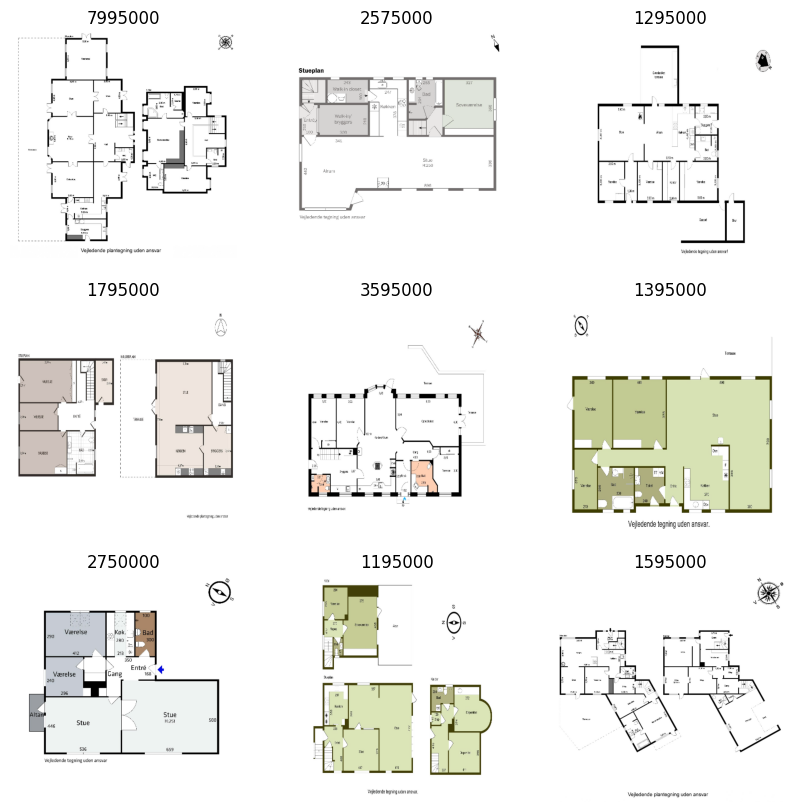

In [14]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(train_images[0:9], train_df["price"][0:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis("off")

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model (without including top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new top layers for regression
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(1, activation="linear")
])

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 15, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 115200)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               58982912  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73829185 (281.64 MB)
Trainable params: 59114497 (225.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [17]:
# Train the model
history = model.fit(train_images, train_df["price"], validation_data=(valid_images, valid_df["price"]), epochs=2)

Epoch 1/2
20/20 [==============================] - 301s 15s/step - loss: 2807288.5000 - val_loss: 2613718.5000
Epoch 2/2
20/20 [==============================] - 300s 15s/step - loss: 2801409.7500 - val_loss: 2605580.0000


In [18]:
model.evaluate(test_images, test_df["price"])

# Make predictions
predictions = model.predict(test_images)

7/7 [==============================] - 70s 10s/step


R2 score: -1.33
Mean Absolute Error: 2680658.01
Mean Squared Error: 12587949565062.16


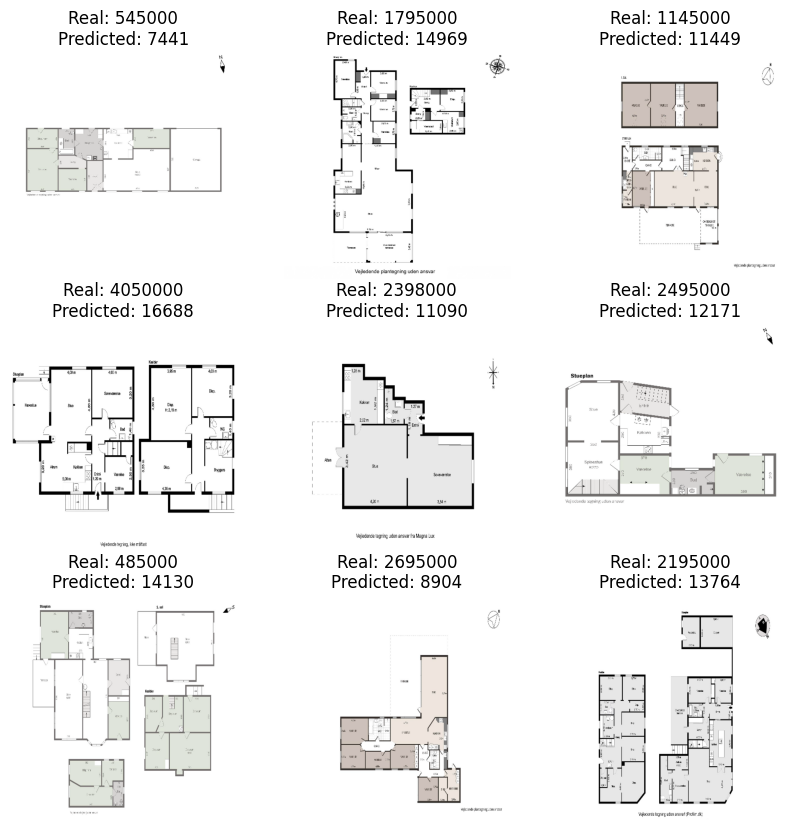

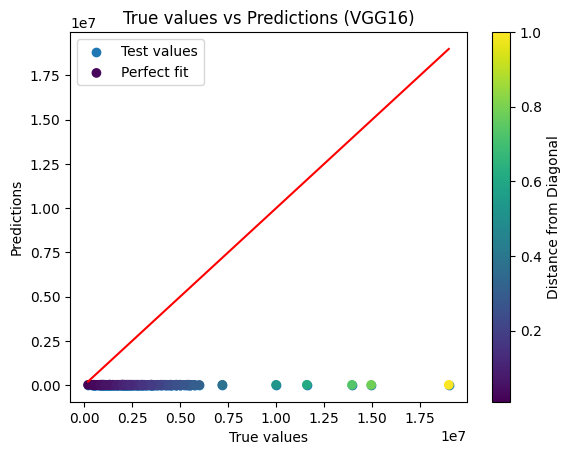

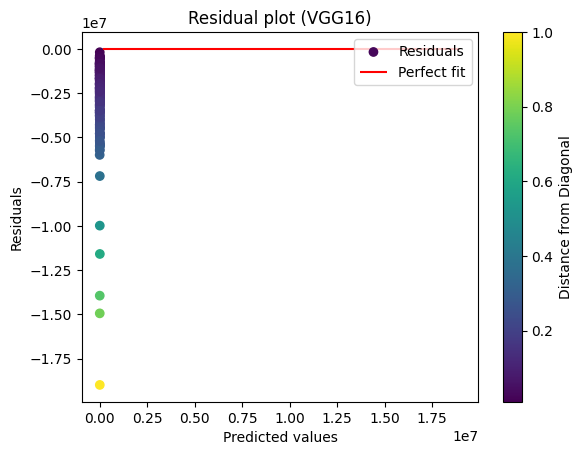

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

real_prices = test_df['price'].values
predicted_prices = predictions.flatten()

# Print the R2 score, MAE and MSE
print(f"R2 score: {r2_score(real_prices, predicted_prices):.2f}")
print(f"Mean Absolute Error: {mae(real_prices, predicted_prices):.2f}")
print(f"Mean Squared Error: {mse(real_prices, predicted_prices):.2f}")

# Plot the predictions
plt.figure(figsize=(10, 10))
for i, (image, label, prediction) in enumerate(zip(test_images[0:9], test_df["price"][0:9], predictions[0:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Real: {label}\nPredicted: {prediction[0]:.0f}")
    plt.axis("off")
plt.show()

# Plot the predictions vs real prices
plot_regression_results('VGG16', real_prices, predicted_prices)